In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
%matplotlib inline

/usr/local/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('http://www.jtash.com/step-data.txt')
data.head()

,date,actual,goal
0,2018-07-29,9250.0,7140.0
1,2018-07-30,6392.0,7360.0
2,2018-07-31,5668.0,7270.0
3,2018-08-01,10286.0,6950.0
4,2018-08-02,5396.0,7290.0


In [3]:
with pm.Model() as model:

    # parameterize the priors with sample mean and standard deviation
    alpha = 1 / data.actual.mean()
    beta = 1 / data.actual.std()

    # normal distribution priors - mu and std for before and after
    mu = pm.Exponential('mu', lam=alpha, shape=[2,])
    sd = pm.Exponential('sd', lam=beta, shape=[2,])

    t = np.arange(data.shape[0])
    tau = pm.DiscreteUniform('tau', lower=0, upper=t.max())
    _mu = pm.math.switch(tau > t, mu[0], mu[1])
    _sd = pm.math.switch(tau > t, sd[0], sd[1])

    # so as you can see, I just have a switchpoint(s)
    
    observation = pm.Normal('observation', mu=_mu, sd=_sd, observed=data.actual)

    start = pm.find_MAP()
    trace = pm.sample(draws=5000, tune=5000, start=start)

/usr/local/anaconda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,139.2, ||grad|| = 0.10198: 100%|██████████| 14/14 [00:00<00:00, 224.23it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sd, mu]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:19<00:00, 1044.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdac8f5acc0>,
      dtype=object)

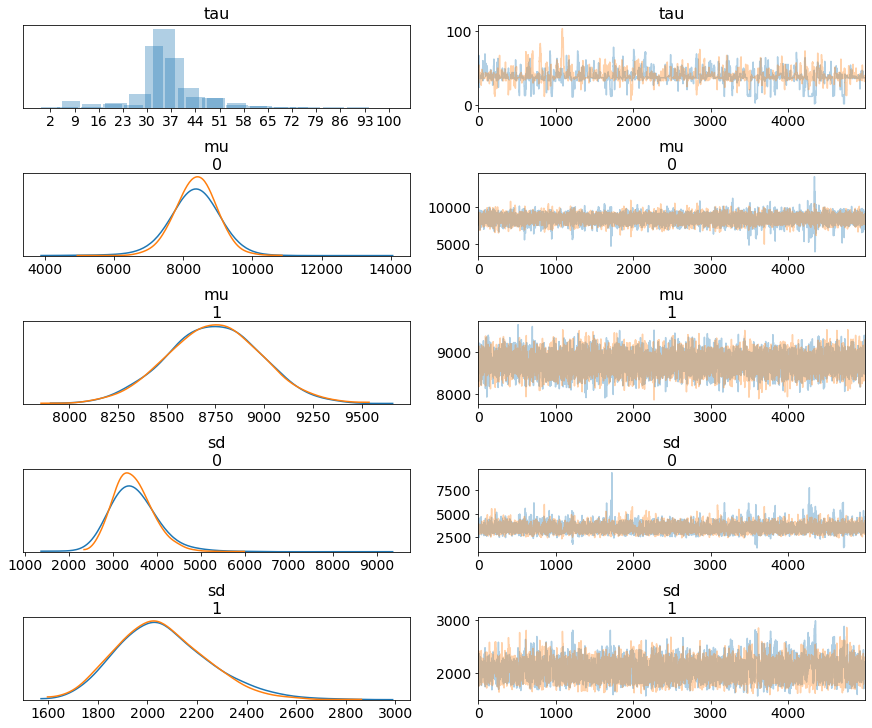

In [4]:
pm.traceplot(trace)

In [5]:
with pm.Model() as model2:

    # parameterize the priors with sample mean and standard deviation
    alpha = 1 / data.actual.mean()
    beta = 1 / data.actual.std()

    # normal distribution priors - mu and std for before and after
    mu = pm.Exponential('mu', lam=alpha, shape=[2,])
    sd = pm.Exponential('sd', lam=beta, shape=[2,])

    t = np.arange(data.shape[0])
    tau = pm.DiscreteUniform('tau', lower=0, upper=t.max())
    _mu = pm.math.switch(tau > t, mu[0], mu[1])
    _sd = pm.math.switch(tau > t, sd[0], sd[1])

    observation = pm.Normal('observation', mu=_mu, sd=_sd, observed=data.actual)

    trace2 = pm.sample(draws=5000, tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sd, mu]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1948.49draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6544112413456672, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2342f0f0>,
      dtype=object)

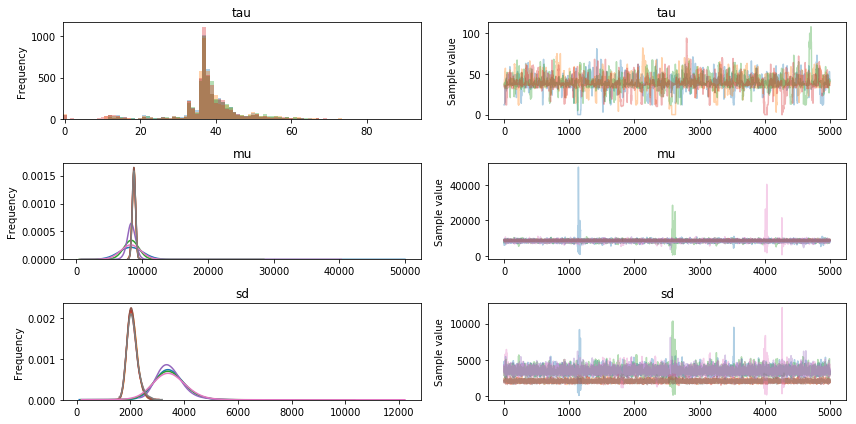

In [6]:
pm.traceplot(trace2)

In [10]:
with pm.Model() as model3:

    # parameterize the priors with sample mean and standard deviation and a derived metric
    alpha = 1 / data.actual.mean()
    beta = 1 / data.actual.std()
    gamma = (alpha+beta/2)

    # normal distribution priors - mu and std for before and after
    mu = pm.Exponential('mu', lam=alpha, shape=[2,])
    sd = pm.Exponential('sd', lam=beta, shape=[2,])
    nu = pm.Exponential('nu', lam=gamma, testval=.1)


    t = np.arange(data.shape[0])
    tau = pm.DiscreteUniform('tau', lower=0, upper=t.max())
    _mu = pm.math.switch(tau > t, mu[0], mu[1])
    _sd = pm.math.switch(tau > t, sd[0], sd[1])
    
    # StudentT has other parameters too. 
    observation = pm.StudentT('observation', nu=nu, mu=_mu, sd=_sd, observed=data.actual)

    trace3 = pm.sample(draws=8000, tune=8000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [nu, sd, mu]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 32000/32000 [00:46<00:00, 690.67draws/s]
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdab288e828>,
      dtype=object)

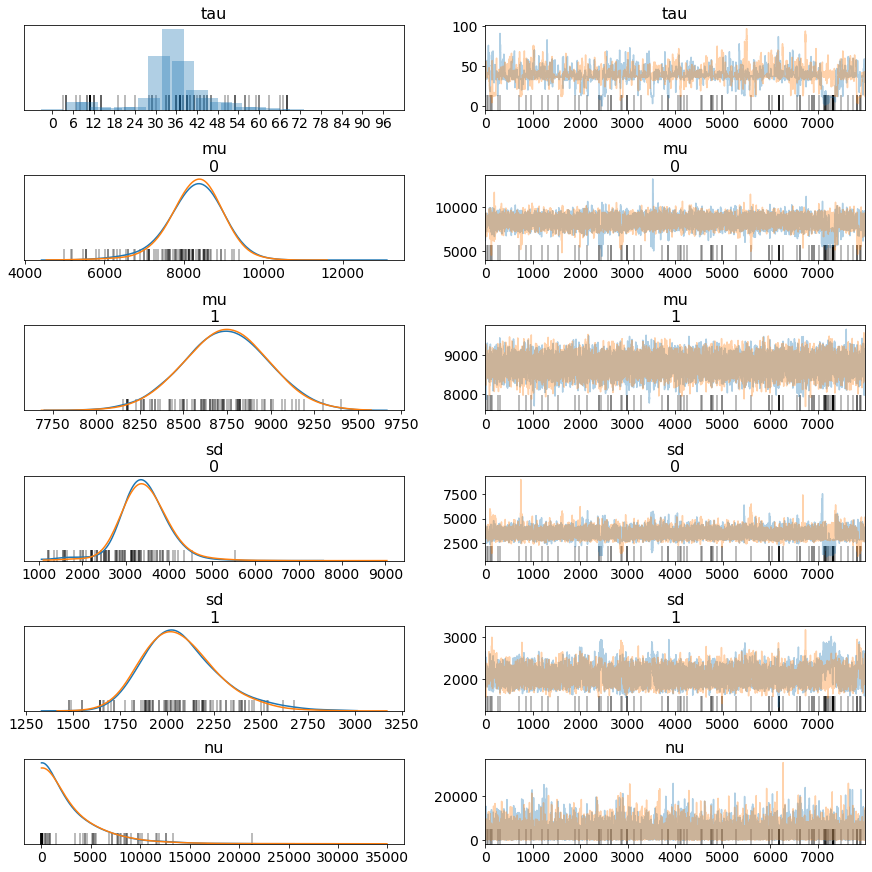

In [11]:
pm.traceplot(trace3)

In [13]:
import theano.tensor as tt
with pm.Model() as marginal:
    # parameterize the priors with sample mean and standard deviation and a derived metric
    alpha = 1 / data.actual.mean()
    beta = 1 / data.actual.std()
    gamma = (alpha+beta/2)

    # normal distribution priors - mu and std for before and after
    mu = pm.Exponential('mu', lam=alpha, shape=[2,])
    sd = pm.Exponential('sd', lam=beta, shape=[2,])
    nu = pm.Exponential('nu', lam=gamma, testval=.1)
    Z_latent = pm.Uniform('Z_latent', 0., 1., shape=[2,])
    lam = pm.Deterministic('lambda', Z_latent.mean())
    Z = pm.Deterministic('Z',
                         pm.theanof.tt_rng().binomial(
                             n=1, p=Z_latent, size=(2,)))

    tau = pm.DiscreteUniform('tau', lower=0, upper=t.max())
    mix_logp = pm.math.logsumexp(
    tt.log(1. - Z_latent) + tau, axis=0)
    tau_marginal = pm.Potential('tau_marginal', mix_logp)
    _mu = pm.math.switch(tau_marginal > t, mu[0], mu[1])
    _sd = pm.math.switch(tau_marginal > t, sd[0], sd[1])

       # StudentT has other parameters too. 
    observation = pm.StudentT('observation', nu=nu, mu=_mu, sd=_sd, observed=data.actual)
    
    # again I had to remove target accept and only have switchpoints
    trace_marginal = pm.sample(draws=8000, tune=8000)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [Z_latent, nu, sd, mu]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 32000/32000 [06:12<00:00, 85.89draws/s] 
There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
There were 398 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdab27c05c0>,
      dtype=object)

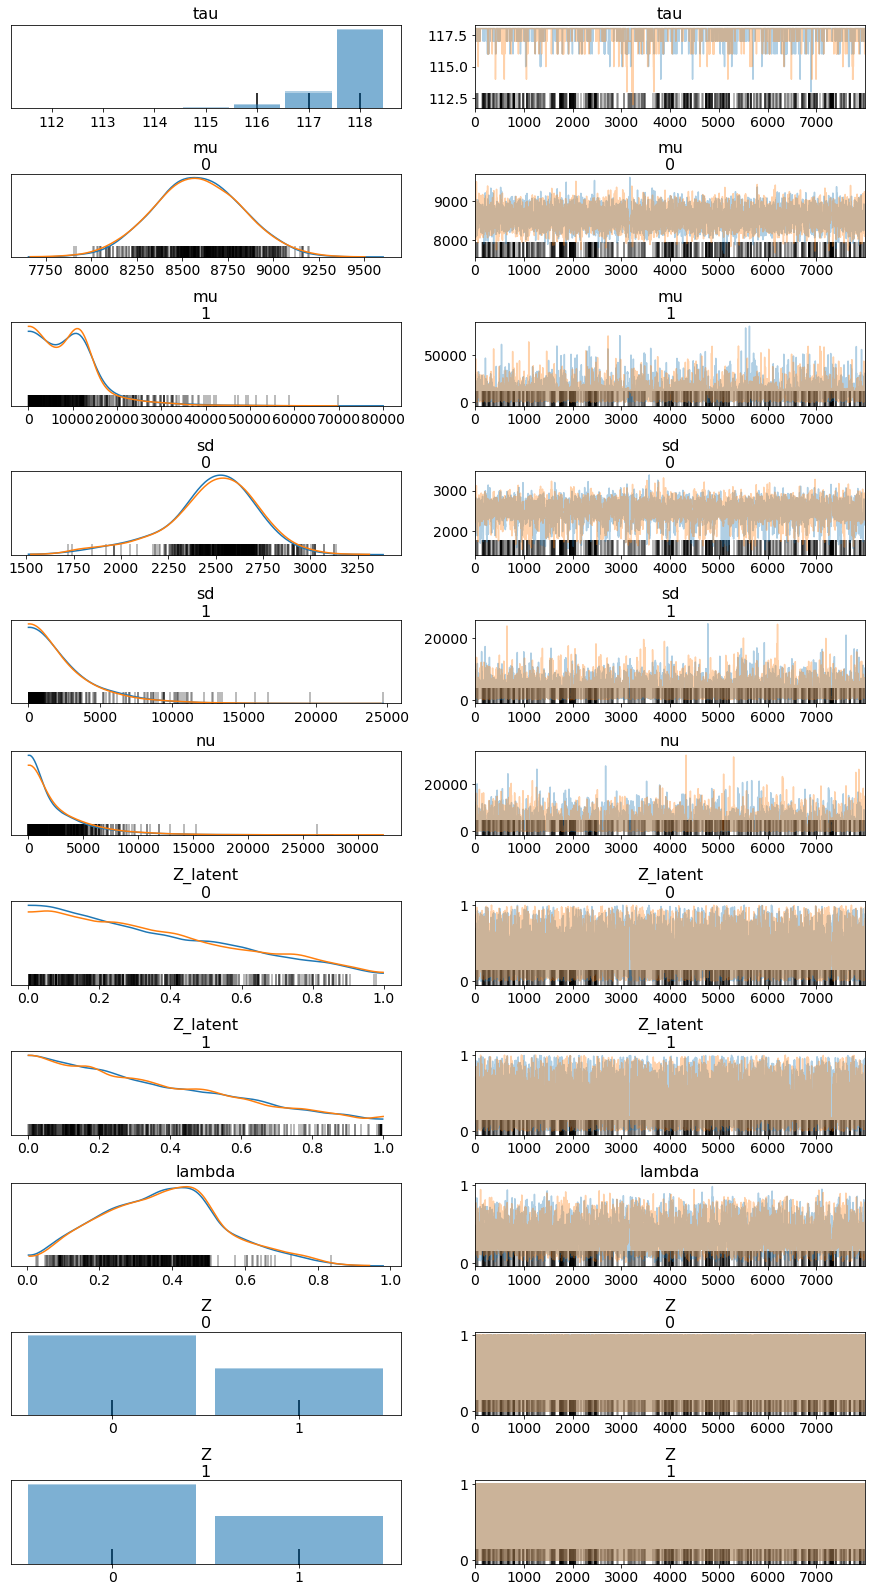

In [14]:
pm.traceplot(trace_marginal)

In [ ]:
# now I want to replace the switchpoint with a logistic function....